<div class="markdown-google-sans">
  <h1>Introduction to feed-forward neural networks</h2>
</div>





In [ ]:
# ==== Environment Setup ====
# Detects Colab vs local and provides cross-platform utilities

import os
import sys

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("✓ Running on Google Colab")
else:
    print("✓ Running locally")

def download_file(url: str, filename: str) -> str:
    """Download file if it doesn't exist. Works on both Colab and local."""
    if os.path.exists(filename):
        print(f"✓ {filename} already exists")
        return filename
    
    print(f"Downloading {filename}...")
    if IN_COLAB:
        import subprocess
        subprocess.run(['wget', '-q', url, '-O', filename], check=True)
    else:
        import urllib.request
        urllib.request.urlretrieve(url, filename)
    print(f"✓ Downloaded {filename}")
    return filename

In [ ]:
# ==== Device Setup ====
import torch

def get_device():
    """Get best available device: CUDA > MPS > CPU."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print("✓ Using Apple MPS (Metal)")
    else:
        device = torch.device('cpu')
        print("✓ Using CPU")
    return device

DEVICE = get_device()

---

# Part 2: The Mathematics of Feed-Forward Networks

Before diving into frameworks, let's understand what neural networks actually compute. This connects directly to the gradient descent you implemented in Lab 0.


## 2.1 The Single Neuron

A **neuron** (or **perceptron**) computes a weighted sum of its inputs, adds a bias, then applies an activation function:

$$z = \mathbf{w}^T \mathbf{x} + b = \sum_{i=1}^{n} w_i x_i + b$$

$$a = \sigma(z)$$

where:
- $\mathbf{x} \in \mathbb{R}^n$ is the input vector
- $\mathbf{w} \in \mathbb{R}^n$ is the weight vector
- $b \in \mathbb{R}$ is the bias term
- $\sigma$ is the **activation function** (e.g., ReLU, sigmoid, tanh)

**This is exactly linear regression with a non-linear transformation at the end!**


## 2.2 Why Non-Linearity?

**Key insight**: Without non-linear activations, stacking layers is pointless.

If we use linear activations $\sigma(z) = z$, then:

$$\text{Layer 2} \circ \text{Layer 1} = W_2(W_1 \mathbf{x} + b_1) + b_2 = (W_2 W_1)\mathbf{x} + (W_2 b_1 + b_2)$$

This is just another linear transformation! A 100-layer network with linear activations collapses to a single linear layer.

**Non-linear activations break this**, allowing networks to learn complex, non-linear decision boundaries.

<details>
<summary><b>🤔 Question:</b> Why can't we use linear activations everywhere?</summary>

**Answer:** The composition of linear functions is linear. Without non-linearity, any depth of network is mathematically equivalent to a single linear transformation $\mathbf{y} = W\mathbf{x} + b$. Non-linear activations allow the network to approximate arbitrarily complex functions (universal approximation theorem).
</details>


## 2.3 Forward Propagation

In a multi-layer network, we compute activations layer by layer:

$$\mathbf{z}^{(l)} = W^{(l)} \mathbf{a}^{(l-1)} + \mathbf{b}^{(l)}$$
$$\mathbf{a}^{(l)} = \sigma(\mathbf{z}^{(l)})$$

where $\mathbf{a}^{(0)} = \mathbf{x}$ (the input).

**Dimensions** (critical to understand!):
- If layer $l$ has $n_l$ neurons and layer $l-1$ has $n_{l-1}$ neurons:
- $W^{(l)} \in \mathbb{R}^{n_l \times n_{l-1}}$
- $\mathbf{b}^{(l)} \in \mathbb{R}^{n_l}$
- $\mathbf{a}^{(l)} \in \mathbb{R}^{n_l}$

<details>
<summary><b>🤔 Question:</b> If the input has 8 features and the first hidden layer has 1024 neurons, what is the shape of W<sup>(1)</sup>?</summary>

**Answer:** $W^{(1)} \in \mathbb{R}^{1024 \times 8}$. Each of the 1024 neurons needs a weight for each of the 8 input features.
</details>


## 2.4 Common Activation Functions

| Function | Formula | Range | Notes |
|----------|---------|-------|-------|
| **ReLU** | $\max(0, z)$ | $[0, \infty)$ | Default choice, fast, sparse |
| **Sigmoid** | $\frac{1}{1+e^{-z}}$ | $(0, 1)$ | Output layer for binary classification |
| **Tanh** | $\frac{e^z - e^{-z}}{e^z + e^{-z}}$ | $(-1, 1)$ | Zero-centred, used in RNNs |
| **Softmax** | $\frac{e^{z_i}}{\sum_j e^{z_j}}$ | $(0, 1)$, sums to 1 | Output layer for multi-class |

**For hidden layers, ReLU is the standard choice** due to computational efficiency and reduced vanishing gradient problems.


## 2.5 Backpropagation: Gradient Descent on Steroids

**Core idea**: Backprop is just the chain rule applied systematically.

For a loss function $L$ and parameters $\theta = \{W^{(l)}, \mathbf{b}^{(l)}\}_{l=1}^{L}$:

$$\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial \mathbf{a}^{(L)}} \cdot \frac{\partial \mathbf{a}^{(L)}}{\partial \mathbf{z}^{(L)}} \cdot \frac{\partial \mathbf{z}^{(L)}}{\partial \mathbf{a}^{(L-1)}} \cdots \frac{\partial \mathbf{z}^{(l)}}{\partial W^{(l)}}$$

**This is the same gradient descent from Lab 0**, just with more parameters!

In Lab 0, you computed:
$$\frac{\partial L}{\partial w} = -\frac{2}{n}\sum_{i=1}^{n} x_i(y_i - \hat{y}_i)$$

Neural networks do the same thing, but:
1. More weights (thousands to millions)
2. Chain rule through multiple layers
3. Frameworks handle this automatically via **automatic differentiation**

<details>
<summary><b>🤔 Question:</b> How does backpropagation relate to the gradient descent you implemented in Lab 0?</summary>

**Answer:** They're the same algorithm! In Lab 0, you manually derived $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$ for linear regression. Backpropagation extends this to compute gradients for all weights in all layers by applying the chain rule. Deep learning frameworks automate this through computational graphs and automatic differentiation.
</details>


## 2.6 Connection to Lab 0: Linear Regression as a Neural Network

**An MLP with no hidden layers is exactly linear regression:**

```
sklearn.linear_model.LinearRegression
    ≡
sklearn.neural_network.MLPRegressor(hidden_layer_sizes=[])
```

Adding hidden layers allows the network to learn **non-linear feature representations** automatically—this is the power of deep learning.


In [ ]:
# Visualise: Linear regression is a 1-layer neural network
print("""
Linear Regression (Lab 0):          Single-Layer Neural Network:
                                    
  x₁ ─────┐                           x₁ ──w₁──┐
  x₂ ─────┼──→ Σwᵢxᵢ + b → ŷ          x₂ ──w₂──┼──→ Σ + b → ŷ
  ...     │                           ...      │
  xₙ ─────┘                           xₙ ──wₙ──┘

Adding hidden layers:

  x₁ ──┐      ┌──h₁──┐
  x₂ ──┼──W₁──┼──h₂──┼──W₂──→ ŷ
  ...  │      │ ...  │
  xₙ ──┘      └──hₖ──┘
       
  Input    Hidden    Output
  Layer    Layer     Layer
""")


# scikit-learn


`scikit-learn` is a widely used open-source Python library for machine learning. It offers a broad range of algorithms for both supervised (e.g., classification, regression) and unsupervised (e.g., clustering, dimensionality reduction) learning tasks.

Beyond algorithms, it provides an integrated set of tools for the entire machine learning workflow, including:
- data preprocessing (scaling, encoding, splitting),
- model fitting and training,
- hyperparameter tuning,
- model selection & evaluation metrics,

alongside many other utilities that help build, test, and deploy machine learning models efficiently.

### Loading the data



In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error, mean_absolute_error

GLOBAL_RANDOM_STATE = 21


In [ ]:
data, target = fetch_california_housing(return_X_y=True, as_frame=True) # returns a tuple: X (features / predictors) & y (target labels)

In [ ]:
data.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24


<Axes: title={'center': 'Geographical distribution of housing values'}, xlabel='Latitude', ylabel='Longitude'>

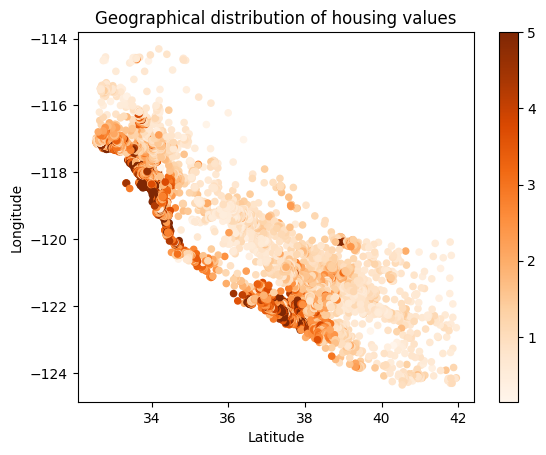

In [ ]:
data.plot.scatter(x='Latitude', y='Longitude', title='Geographical distribution of housing values', c=target, cmap='Oranges') # uses target variable to colour

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data,
                                                    target,
                                                    test_size=.2,
                                                    random_state=GLOBAL_RANDOM_STATE,
                                                    shuffle=True)

### Standardising the data

Standardising rescales features so they all have mean 0 and standard deviation 1 $→$ all on same footing regardless of their original units. This prevents features with large numeric ranges from dominating models that are sensitive to scale.

column-wise standardisation:

$x_{scaled}​ = \frac{x−\mu}{\sigma}$​

In [ ]:
ScalerX = StandardScaler() # from sklearn.preprocessing

X_train_stand = ScalerX.fit_transform(X_train) # fit (computes mean & std) -> then transform
X_test_stand = ScalerX.transform(X_test) # NB: only 'transform' -> question: why not fit?

print(X_train_stand.mean(axis=0))
print(X_train_stand.std(axis=0))


[-6.70759744e-17 -9.88120008e-17  1.65134917e-16  2.69164536e-16
  7.27239113e-17 -1.12689789e-17 -1.67281133e-15 -2.08274397e-15]
[1. 1. 1. 1. 1. 1. 1. 1.]


### Constructing the model


In [ ]:
from sklearn.neural_network import MLPRegressor # as opposed to a MLPClassifier -> class question: how would these be different?

# TL;DR: MLP = THE standard / vanilla NN / most basic building block of more complex model architectures.

# Multi-Layer Perceptron (MLP) is a type of neural network composed of layers of interconnected nodes (neurons),
# each neuron applies a weighted sum of its inputs followed by a nonlinear activation function.
# By stacking multiple layers -> MLPs can learn complex patterns and relationships in data.
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

In [ ]:
sklearn_model = MLPRegressor(hidden_layer_sizes=[2**10, 2**7, 2**5],
                             max_iter=5, # epochs
                             batch_size=200, # samples per gradient update (stochastic gradient descent w/ minibatches)
                             validation_fraction=.1,
                             early_stopping=True,  # this won't be realistically reached as we have set max_iter to 5
                             verbose=True) # -> shows progress & loss at each iteration

# NB in sklearn input size and output size are not specified; rather they are inferred from data when we fit: sklearn_model.fit(X_train, Y_train)

# what is input size?
print('X shape:', X_train.shape)
# output size?
print('y shape:', Y_train.shape, '\n', '-'*10)

X shape: (16512, 8)
y shape: (16512,) 
 ----------


<details>
<summary><b>🤔 Predict before running:</b> Will R² be positive or negative after just 5 epochs on unstandardised data?</summary>

**Answer:** Likely negative or close to zero. R² measures how much better the model is than simply predicting the mean. With only 5 epochs on unstandardised data, the model hasn't had enough training to learn meaningful patterns. Unstandardised features also make optimisation harder, as different scales cause uneven gradient magnitudes.
</details>


In [ ]:
sklearn_model.fit(X_train, Y_train)

# NB: in regression validation score is R^2
# 1 = perfect explain; 0 = no better than predicting the mean; neg = worse than mean

Iteration 1, loss = 495.50957822
Validation score: -0.052741
Iteration 2, loss = 0.73720314
Validation score: 0.022078
Iteration 3, loss = 0.62909149
Validation score: 0.101226
Iteration 4, loss = 0.56958489
Validation score: 0.263874
Iteration 5, loss = 0.49957374
Validation score: 0.388047


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(batch_size=200, early_stopping=True,
             hidden_layer_sizes=[1024, 128, 32], max_iter=5, verbose=True)

We now have a partially trained NN to predict house prices based on a set of inputs. Notice how other than standardising, we didn't have to do any feature engineering etc - this representational learning was done implicitly within the model.

In [ ]:
#@title TASK 1: implement the same model for the standardised data, experimenting with higher/lower batch sizes

sklearn_model_stand = MLPRegressor(hidden_layer_sizes=[2**10, 2**7, 2**5], max_iter=3, early_stopping=True, verbose=True)
sklearn_model_stand.fit(X_train_stand, Y_train)

Iteration 1, loss = 0.52915170
Validation score: 0.677831
Iteration 2, loss = 0.20331397
Validation score: 0.726441
Iteration 3, loss = 0.18466985
Validation score: 0.739486


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(early_stopping=True, hidden_layer_sizes=[1024, 128, 32],
             max_iter=3, verbose=True)

### Evaluating the models

We can use different metrics to evaluate the performance of the model:
- Mean Absolute Error
- Mean Squared Error
- $R^2$ or coefficient of determination
- others (use case dependent)


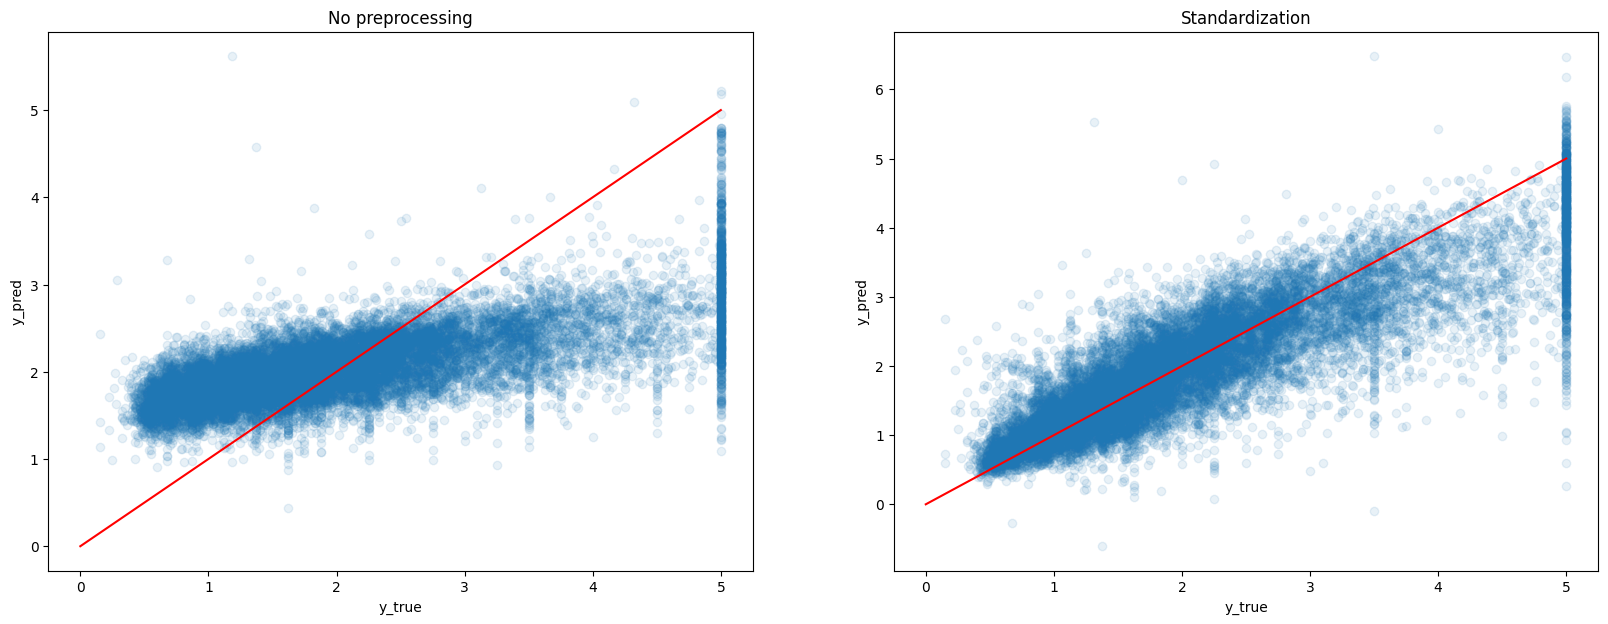

In [ ]:
# plotting ground truth vs predicted values

fig, axes = plt.subplots(1,2, # number of rows; cols
                         figsize=(20,7)) # width 20, height 7

model_input_title = [(sklearn_model, X_train, 'No preprocessing'), (sklearn_model_stand, X_train_stand, 'Standardisation')]

for i in range(2):
  model, input, title = model_input_title[i]
  _ = axes[i].scatter(Y_train, model.predict(input), alpha=.1)
  _ = axes[i].plot(range(6),'r')
  _ = axes[i].set_xlabel('y_true')
  _ = axes[i].set_ylabel('y_pred')
  _ = axes[i].set_title(title)


The red line represents the ideal scenario where $y_{true} = y_{pred}$. A perfect model would have all points on this line.

We see that **standardisation is critical** for neural network training.

<details>
<summary><b>🤔 Question:</b> Why does standardisation help gradient descent converge faster?</summary>

**Answer:** When features have different scales (e.g., one ranges 0-1, another 0-1000), the loss landscape becomes elongated. Gradients in different directions have very different magnitudes, causing optimisation to oscillate. Standardisation makes the loss landscape more spherical, allowing gradient descent to take more direct paths to the minimum.
</details>


In [ ]:
#@title TASK 2: print MSE and MAE. What might be the downsides of using such metrics to evaluate the performance of the algorithm?

# save the predictions of each model
Y_pred, Y_pred_stand = sklearn_model.predict(X_test), sklearn_model_stand.predict(X_test_stand)

# MAE
mae, mae_stand = mean_absolute_error(Y_pred, Y_test), mean_absolute_error(Y_pred_stand, Y_test)

# MSE
mse, mse_stand = mean_squared_error(Y_pred, Y_test), mean_squared_error(Y_pred_stand, Y_test)

print(f"Mean absolute error of predictions: {mae:.5f} (without standardisation), {mae_stand:.5f} (with standardisation)")
print(f"Mean squared error of predictions: {mse:.5f} (without standardisation), {mse_stand:.5f} (with standardisation)")

Mean absolute error of predictions: 0.72221 (without standardization), 0.42287 (with standardization)
Mean squared error of predictions: 0.85212 (without standardization), 0.37023 (with standardization)


### MAE vs MSE

**MAE**
- avg of the absolute differences between the predicted and actual values.
$$MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|$$

- in the same units as the target variable,
- robust to outliers

**MSE**
- avg of squared differences between the predicted and actual values.
$$MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

- units harder to interpret directly,
- more sensitive to outliers (squares errors),
- has some nice mathematical properties.

---

### Use cases:

- *Use MAE when you want a robust metric that is less affected by outliers, or when you want the error to be in the same units as the target variable for easier interpretation.*

- *Use MSE when you want to heavily penalize large errors (outliers) or when you are working with models that are optimised using squared error (like most linear regression models).*

---

### Downsides to both:
1. **Sensitivity to scale** - is MAE/MSE of 100 good or bad? depends on the scale of the target var!
2. **Treats all errors equally** - is an underestimate / false positive the same as an over-estimate / false negative?
3. **Contain limitted info** - a single number summarising performance. Don't tell you where the errors are occurring (e.g., are they concentrated in a specific range of the target variable or for certain types of data instances?), or why the errors are happening.

# Deep Learning frameworks

`scikit-learn` is extremely user-friendly and recommended when getting warmed-up with ML. However, the implemented models are not flexible enough to suit tailored model implementation. In particular:

The most well-known DL frameworks are:
<ul>
<li><code>tensorflow</code> backed by Google</li>
<li><code>pytorch</code> backed by Meta</li>
<li><code>JAX</code> backed by Google</li>
</ul>


During the lab, we will mostly use `pytorch` - of course you are free to use any library of your choice for assignments and tutorials.

To get familiar with the basics of all three frameworks, we will implement a simple neural network for each of them. Our Feed-Forward NN (FNN) will contain 3 hidden layers (of size $2^{10}, 2^7, 2^5$) and a final layer with a sigmoid activation.

# PyTorch


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

### PyTorch input objects: Datasets & Dataloaders

First we need to convert our data into a PyTorch **Dataset** object.

This can then be loaded into a **Dataloader**, to easily iterate over the data in mini-batches during the training process.

In [ ]:
# torch only accepts torch.Tensors as input
X_train_torch, X_test_torch = torch.tensor(X_train.values), torch.tensor(X_test.values)
Y_train_torch, Y_test_torch = torch.tensor(Y_train.values), torch.tensor(Y_test.values)

# from Tensors to Dataset objects (PyTorch specific)
train_dataset = TensorDataset(X_train_torch, Y_train_torch)
test_dataset  = TensorDataset(X_test_torch, Y_test_torch)

# ---
# Below is a more granular / manual workflow for those who want more control:

"""
# torch only accepts torch.Tensors as input
X_train_torch, X_test_torch = torch.tensor(X_train), torch.tensor(X_test)
Y_train_torch, Y_test_torch = torch.tensor(Y_train), torch.tensor(Y_test)

class MyDataset(Dataset): # inherit from torch's Dataset class

  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self): # required by PyTorch's Dataset class: necessary for batching
    return len(self.X)

  def __getitem__(self, idx): # also required: allows retrieving single sample given an index
    return self.X[idx], self.Y[idx]


train_dataset = MyDataset(X_train_torch, Y_train_torch) # from a tensor object to a dataset object
test_dataset = MyDataset(X_test_torch, Y_test_torch)
"""

# Explanation of the above
# The `torch.utils.data.Dataset` class is an abstract base class provided / required by PyTorch. It defines a standard interface that other dataset classes must follow.

# To use our data with `PyTorch`'s data loading utilities (like `DataLoader`), we need an object that implements the methods required by the `Dataset` interface. The two essential methods are:

# 1. `__len__(self)`: This method must return the total number of samples in your dataset.
# 2. `__getitem__(self, idx)`: This method must return a single sample (input features and corresponding target label) when given an index idx.

# We will call this `MyDataset`.


"\n# torch only accepts torch.Tensors as input\nX_train_torch, X_test_torch = torch.tensor(X_train), torch.tensor(X_test)\nY_train_torch, Y_test_torch = torch.tensor(Y_train), torch.tensor(Y_test)\n\nclass MyDataset(Dataset): # inherit from torch's Dataset class\n\n  def __init__(self, X, Y):\n    self.X = X\n    self.Y = Y\n\n  def __len__(self): # required by PyTorch's Dataset class: necessary for batching\n    return len(self.X)\n\n  def __getitem__(self, idx): # also required: allows retrieving single sample given an index\n    return self.X[idx], self.Y[idx]\n\n\ntrain_dataset = MyDataset(X_train_torch, Y_train_torch) # from a tensor object to a dataset object\ntest_dataset = MyDataset(X_test_torch, Y_test_torch)\n"

With this set up, we're ready to define our NN architectures in PyTorch.

### Defining NN Architecture in Pytorch

Unlike sklearn, PyTorch is more involved;
1. we need to explicitly specify our layers, activations, and the transformation dimensions.
2. we need to explicitly lay out a workflow for training the network.

In [ ]:
# nn.Sequential: layers execute in order, no custom forward() needed
# nn.Module: use when you need custom logic in forward()

TorchModel = nn.Sequential(
    nn.Linear(8, 2**10),      # Input -> Hidden 1 (8 -> 1024)
    nn.ReLU(),
    nn.Linear(2**10, 2**7),   # Hidden 1 -> Hidden 2 (1024 -> 128)
    nn.ReLU(),
    nn.Linear(2**7, 2**5),    # Hidden 2 -> Hidden 3 (128 -> 32)
    nn.ReLU(),
    nn.Linear(2**5, 1)        # Hidden 3 -> Output (32 -> 1)
)

print(TorchModel)
print(f"\nTotal parameters: {sum(p.numel() for p in TorchModel.parameters()):,}")


In [ ]:
def torch_train(model,
                dataset,
                optimizer,
                criterion=nn.MSELoss(),
                batch_size=32,
                epochs=5,
                shuffle=True,
                verbose=False):
    """Train a PyTorch model and return loss history."""
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    model.train()
    history = []  # Track loss for plotting
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i, (X, Y) in enumerate(dataloader):
            X = X.float()
            Y = Y.float().unsqueeze(-1)  # Fix shape: [batch] -> [batch, 1]
            
            optimizer.zero_grad()  # Clear gradients from previous iteration
            preds = model(X)
            loss = criterion(preds, Y)
            loss.backward()  # Compute gradients via backprop
            optimizer.step()  # Update weights: w = w - lr * grad
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(dataloader)
        history.append(avg_loss)
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.5f}")
    
    return model, history


<details>
<summary><b>🤔 Question:</b> Why must we call <code>optimizer.zero_grad()</code> before each batch?</summary>

**Answer:** PyTorch **accumulates** gradients by default. If we don't zero them, gradients from the previous batch would be added to the current batch's gradients, leading to incorrect weight updates. This accumulation feature is useful for gradient accumulation with large batch sizes, but for standard training we need to clear gradients each iteration.
</details>


In [ ]:
# Model already instantiated above via nn.Sequential
torch_arch = TorchModel

optimizer = optim.Adam(torch_arch.parameters(), lr=1e-2)
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning rate: {optimizer.defaults['lr']}")


TorchModel(
  (layer1): Linear(in_features=8, out_features=1024, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=1024, out_features=128, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=128, out_features=32, bias=True)
  (relu3): ReLU()
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [ ]:
# Train the model
model, loss_history = torch_train(torch_arch, train_dataset, optimizer, epochs=10, verbose=True)

# Plot loss curve
plt.figure(figsize=(8, 4))
plt.plot(loss_history, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('PyTorch Training Loss')
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# @title Make predictions

model.eval()

with torch.no_grad():  # no gradient tracking needed for inference
    y_pred = model(X_test_torch.float())

y_pred # y_pred will be a tensor of shape (n_test, 1) (regression)

y_pred_np = y_pred.numpy().flatten()
y_pred_np



array([2.1483724, 2.113012 , 2.1070144, ..., 2.526202 , 2.3851974,
       2.6271007], dtype=float32)

<details>
<summary><b>🤔 Question:</b> What's the difference between <code>model.train()</code> and <code>model.eval()</code>?</summary>

**Answer:** These methods switch the model's behaviour for layers like **Dropout** and **BatchNorm**:
- `train()`: Dropout randomly zeros neurons; BatchNorm uses batch statistics
- `eval()`: Dropout is disabled; BatchNorm uses running averages

For inference, always use `model.eval()` to get deterministic, consistent predictions.
</details>


#Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.nn import relu, tanh

tf.random.set_seed(GLOBAL_RANDOM_STATE)

In [ ]:
# @title Data to np arrays

# like with PyTorch, Tensorflow does not accept pd.DataFrames
# unlike PyTorch, Tensorflow wants np arrays
X_train_np, Y_train_np, X_test_np, Y_test_np =  X_train.values, Y_train.values, X_test.values, Y_test.values

In [ ]:
# Define model architecture using modern Keras API
from tensorflow.keras.layers import Input

TFModel = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit input layer (no deprecation warning)
    Dense(2**10, activation='relu'),   # Hidden layer 1: 1024 neurons
    Dense(2**7, activation='relu'),    # Hidden layer 2: 128 neurons
    Dense(2**5, activation='relu'),    # Hidden layer 3: 32 neurons
    Dense(1)                           # Output layer: linear activation for regression
])

TFModel.compile(optimizer='adam', loss='mse')

# Train and capture history
tf_history = TFModel.fit(X_train_np, Y_train_np, 
                         batch_size=32, 
                         epochs=10, 
                         validation_split=0.1,
                         verbose=1)


In [ ]:
# Plot TensorFlow training loss
plt.figure(figsize=(8, 4))
plt.plot(tf_history.history['loss'], 'b-', label='Training', linewidth=2)
plt.plot(tf_history.history['val_loss'], 'r--', label='Validation', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('TensorFlow Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Make predictions
tf_predictions = TFModel.predict(X_test_np, verbose=0)
tf_mse = mean_squared_error(Y_test_np, tf_predictions)
print(f"TensorFlow Test MSE: {tf_mse:.4f}")


# JAX

JAX = NumPy on accelerators (CPU/GPU/TPU) + automatic differentiation.
- Functional programming
- Closer to raw maths / NumPy
    - Very natural for researchers prototyping new algorithms.
    - You write plain NumPy-like code, then decorate with grad, jit, etc.
- *Can* be more efficiently implemented than PyTorch or TensorFlow

In [ ]:
import jax
import jax.numpy as jnp
from jax import value_and_grad

In [ ]:
def jax_dense_layer(x, weights, relu=False):
    """Dense layer: Wx + b with optional ReLU."""
    W, b = weights
    out = jnp.dot(x, W.T) + b
    if relu:
        out = jnp.maximum(0, out)
    return out

def jax_init_weights(shapes, input_shape, output_shape, seed=42):
    """Initialise weights for all layers."""
    weights = []
    key = jax.random.PRNGKey(seed)
    
    for i, shape in enumerate(shapes):
        key, subkey = jax.random.split(key)
        in_dim = input_shape if i == 0 else shapes[i-1]
        # Xavier initialisation
        scale = jnp.sqrt(2.0 / (in_dim + shape))
        w = jax.random.normal(subkey, (shape, in_dim)) * scale
        b = jnp.zeros(shape)
        weights.append([w, b])
    
    # Output layer
    key, subkey = jax.random.split(key)
    scale = jnp.sqrt(2.0 / (shapes[-1] + output_shape))
    w_out = jax.random.normal(subkey, (output_shape, shapes[-1])) * scale
    b_out = jnp.zeros(output_shape)
    weights.append([w_out, b_out])
    
    return weights

def jax_forward(x, weights):
    """Forward pass through all layers."""
    for i, layer_weights in enumerate(weights[:-1]):
        x = jax_dense_layer(x, layer_weights, relu=True)
    # Output layer (no activation for regression)
    x = jax_dense_layer(x, weights[-1], relu=False)
    return x

def jax_mse_loss(weights, x, y):
    """MSE loss function."""
    pred = jax_forward(x, weights)
    return jnp.mean((pred - y) ** 2)

def jax_train(layer_sizes, torch_dataset, batch_size=32, epochs=10, lr=0.01, seed=42):
    """Train JAX model and return weights + loss history."""
    dataloader = DataLoader(torch_dataset, batch_size=batch_size, shuffle=True)
    history = []
    weights = None
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0
        
        for X_batch, Y_batch in dataloader:
            X = jnp.array(X_batch.numpy())
            Y = jnp.array(Y_batch.numpy())[:, None]
            
            # Initialise weights on first batch
            if weights is None:
                weights = jax_init_weights(layer_sizes, X.shape[-1], 1, seed)
            
            # Compute loss and gradients
            loss, grads = value_and_grad(jax_mse_loss)(weights, X, Y)
            
            # Update weights
            weights = [[w - lr * dw, b - lr * db] 
                      for (w, b), (dw, db) in zip(weights, grads)]
            
            epoch_loss += loss
            n_batches += 1
        
        avg_loss = epoch_loss / n_batches
        history.append(float(avg_loss))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    return weights, history

# Train JAX model
jax_weights, jax_history = jax_train([2**10, 2**7, 2**5], train_dataset, epochs=10)


In [ ]:
# Plot JAX training loss
plt.figure(figsize=(8, 4))
plt.plot(jax_history, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('JAX Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

# Evaluate on test set
X_test_jax = jnp.array(X_test.values)
Y_test_jax = jnp.array(Y_test.values)
jax_predictions = jax_forward(X_test_jax, jax_weights)
jax_mse = float(jnp.mean((jax_predictions.squeeze() - Y_test_jax) ** 2))
print(f"JAX Test MSE: {jax_mse:.4f}")


---

# Part 7: Exercises & Exploration


## Exercise 1: Hyperparameter Exploration

Explore how different hyperparameters affect training. Run the cell below and observe the effects.


In [ ]:
def train_and_evaluate(hidden_sizes, lr, batch_size, epochs=10):
    """Train a model with given hyperparameters and return final loss."""
    # Build model dynamically
    layers = []
    in_size = 8
    for h in hidden_sizes:
        layers.extend([nn.Linear(in_size, h), nn.ReLU()])
        in_size = h
    layers.append(nn.Linear(in_size, 1))
    model = nn.Sequential(*layers)
    
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for epoch in range(epochs):
        for X, Y in dataloader:
            X, Y = X.float(), Y.float().unsqueeze(-1)
            opt.zero_grad()
            loss = criterion(model(X), Y)
            loss.backward()
            opt.step()
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        preds = model(X_test_torch.float())
        mse = F.mse_loss(preds.squeeze(), Y_test_torch.float()).item()
    return mse

# Compare different configurations
configs = [
    {'hidden_sizes': [64], 'lr': 0.01, 'batch_size': 32},           # Shallow
    {'hidden_sizes': [256, 128], 'lr': 0.01, 'batch_size': 32},     # Medium
    {'hidden_sizes': [512, 256, 128], 'lr': 0.01, 'batch_size': 32}, # Deep
    {'hidden_sizes': [256, 128], 'lr': 0.001, 'batch_size': 32},    # Lower LR
    {'hidden_sizes': [256, 128], 'lr': 0.01, 'batch_size': 128},    # Larger batch
]

print("Hyperparameter Exploration Results:")
print("-" * 60)
for cfg in configs:
    mse = train_and_evaluate(**cfg)
    print(f"Arch: {cfg['hidden_sizes']}, LR: {cfg['lr']}, Batch: {cfg['batch_size']} -> MSE: {mse:.4f}")


<details>
<summary><b>🤔 Question:</b> Which configuration performed best? Why might deeper networks not always be better?</summary>

**Answer:** Results vary due to random initialisation, but typically:
- **Deeper isn't always better**: More layers = more parameters = harder to optimise, risk of overfitting
- **Learning rate matters**: Too high causes instability, too low causes slow convergence
- **Batch size tradeoff**: Larger batches are more stable but may generalise worse (sharp minima)

For this relatively simple dataset, a medium-sized network often performs best.
</details>


## Exercise 2: Effect of Standardisation (Quantitative)

Compare training with and without standardised data.


In [ ]:
# Train on raw (unstandardised) data
X_train_raw = torch.tensor(X_train.values).float()
Y_train_raw = torch.tensor(Y_train.values).float()
raw_dataset = TensorDataset(X_train_raw, Y_train_raw)

# Train on standardised data
X_train_std = torch.tensor(X_train_stand).float()
std_dataset = TensorDataset(X_train_std, Y_train_raw)

def train_model(dataset, epochs=20):
    model = nn.Sequential(
        nn.Linear(8, 256), nn.ReLU(),
        nn.Linear(256, 128), nn.ReLU(),
        nn.Linear(128, 1)
    )
    opt = optim.Adam(model.parameters(), lr=0.01)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    history = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for X, Y in loader:
            opt.zero_grad()
            loss = F.mse_loss(model(X).squeeze(), Y)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        history.append(epoch_loss / len(loader))
    return history

raw_history = train_model(raw_dataset)
std_history = train_model(std_dataset)

plt.figure(figsize=(10, 4))
plt.plot(raw_history, 'r-', label='Raw data', linewidth=2)
plt.plot(std_history, 'b-', label='Standardised data', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Impact of Standardisation on Training')
plt.legend()
plt.yscale('log')  # Log scale to see both curves
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss (raw): {raw_history[-1]:.4f}")
print(f"Final loss (standardised): {std_history[-1]:.4f}")
print(f"Improvement: {raw_history[-1] / std_history[-1]:.1f}x lower loss with standardisation")


## Exercise 3: Custom Activation Function

Implement and test a custom activation function.


In [ ]:
# Leaky ReLU: allows small negative values (prevents "dying ReLU" problem)
class LeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.01):
        super().__init__()
        self.negative_slope = negative_slope
    
    def forward(self, x):
        return torch.where(x > 0, x, self.negative_slope * x)

# Compare ReLU vs LeakyReLU vs built-in
x = torch.linspace(-2, 2, 100)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# ReLU
axes[0].plot(x, F.relu(x), 'b-', linewidth=2)
axes[0].set_title('ReLU: max(0, x)')
axes[0].axhline(0, color='k', linewidth=0.5)
axes[0].axvline(0, color='k', linewidth=0.5)
axes[0].grid(True, alpha=0.3)

# Our LeakyReLU
leaky = LeakyReLU(0.1)
axes[1].plot(x, leaky(x), 'g-', linewidth=2)
axes[1].set_title('LeakyReLU (α=0.1)')
axes[1].axhline(0, color='k', linewidth=0.5)
axes[1].axvline(0, color='k', linewidth=0.5)
axes[1].grid(True, alpha=0.3)

# Tanh
axes[2].plot(x, torch.tanh(x), 'r-', linewidth=2)
axes[2].set_title('Tanh')
axes[2].axhline(0, color='k', linewidth=0.5)
axes[2].axvline(0, color='k', linewidth=0.5)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key differences:")
print("- ReLU: Fast, sparse activations, but 'dead neurons' if input always negative")
print("- LeakyReLU: Prevents dead neurons with small negative slope")
print("- Tanh: Zero-centred, bounded output, but vanishing gradients for large |x|")


## Weight Initialisation

**Why does initialisation matter?**

Poor initialisation can cause:
- **Vanishing gradients**: Activations shrink to near-zero, gradients become tiny
- **Exploding gradients**: Activations grow exponentially, gradients become huge

**Common strategies:**

| Method | Formula | Best for |
|--------|---------|----------|
| **Xavier/Glorot** | $W \sim \mathcal{N}(0, \frac{2}{n_{in} + n_{out}})$ | Tanh, Sigmoid |
| **He/Kaiming** | $W \sim \mathcal{N}(0, \frac{2}{n_{in}})$ | ReLU |

PyTorch uses sensible defaults, but for custom architectures, explicit initialisation helps.


In [ ]:
# Visualise effect of initialisation
def forward_pass_stats(init_fn, depth=5, width=256, input_dim=8):
    """Track activation statistics through layers."""
    layers = []
    for i in range(depth):
        in_d = input_dim if i == 0 else width
        layer = nn.Linear(in_d, width)
        init_fn(layer.weight)
        nn.init.zeros_(layer.bias)
        layers.append(layer)
    
    x = torch.randn(100, input_dim)
    means, stds = [], []
    
    for layer in layers:
        x = F.relu(layer(x))
        means.append(x.mean().item())
        stds.append(x.std().item())
    
    return means, stds

# Compare initialisations
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for name, init_fn in [
    ('Xavier', lambda w: nn.init.xavier_normal_(w)),
    ('He (Kaiming)', lambda w: nn.init.kaiming_normal_(w, mode='fan_in')),
    ('Random N(0,1)', lambda w: nn.init.normal_(w, std=1.0)),
]:
    means, stds = forward_pass_stats(init_fn)
    axes[0].plot(range(1, 6), means, 'o-', label=name, linewidth=2)
    axes[1].plot(range(1, 6), stds, 'o-', label=name, linewidth=2)

axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Mean Activation')
axes[0].set_title('Activation Means by Layer')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Std Activation')
axes[1].set_title('Activation Std by Layer')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: He initialisation maintains activation scale through ReLU layers.")
print("Random N(0,1) causes activations to explode or vanish.")


---

# Part 8: Framework Comparison & Summary


## Framework Comparison

| Aspect | sklearn | PyTorch | TensorFlow | JAX |
|--------|---------|---------|------------|-----|
| **Ease of use** | Highest | Medium | Medium | Lower |
| **Flexibility** | Low | High | High | Highest |
| **Debugging** | Easy | Good | Moderate | Harder |
| **Research use** | Rare | Common | Common | Growing |
| **Production** | Simple models | Yes | Yes | Emerging |
| **Automatic differentiation** | No | Yes | Yes | Yes |
| **GPU support** | Limited | Excellent | Excellent | Excellent |

**Recommendations:**
- **sklearn**: Quick prototyping, baselines, traditional ML
- **PyTorch**: Research, flexibility, dynamic computation graphs
- **TensorFlow**: Production deployment, Keras for simplicity
- **JAX**: Cutting-edge research, functional programming, TPU optimisation


## Key Takeaways

1. **Neural networks are gradient descent on steroids** — same algorithm as Lab 0, more parameters

2. **Non-linearity is essential** — without activation functions, deep networks collapse to linear models

3. **Standardisation matters** — different feature scales cause optimisation problems

4. **Forward pass computes predictions** — layer by layer: $\mathbf{a}^{(l)} = \sigma(W^{(l)}\mathbf{a}^{(l-1)} + \mathbf{b}^{(l)})$

5. **Backpropagation computes gradients** — chain rule applied systematically

6. **Frameworks handle the calculus** — you define architecture, they compute gradients


<details>
<summary><b>🤔 Question:</b> When would you choose JAX over PyTorch for a research project?</summary>

**Answer:** Choose JAX when:
- You need **functional transformations** like `vmap` (automatic batching) or `pmap` (parallelisation)
- Working with **TPUs** (JAX has native support)
- Implementing **custom autodiff** or second-order methods
- Your research requires **composable transformations** of functions

Choose PyTorch when:
- You need **dynamic computation graphs** (variable-length sequences, conditional logic)
- **Debugging** ease is important (PyTorch feels like normal Python)
- Using **pre-trained models** from torchvision, transformers, etc.
- Team is already familiar with PyTorch ecosystem
</details>


## Further Reading

- [Deep Learning Book (Goodfellow et al.)](https://www.deeplearningbook.org/) — Chapters 6-8 on FFNs
- [PyTorch Tutorials](https://pytorch.org/tutorials/)
- [JAX Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)
- [3Blue1Brown Neural Networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) — Visual intuition
